In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/indoor-xy-floor/5da958dd46f8266d0737457b_2.csv
/kaggle/input/indoor-xy-floor/5d2709c303f801723c3299ee_1.csv
/kaggle/input/indoor-xy-floor/5d2709c303f801723c3299ee_-1.csv
/kaggle/input/indoor-xy-floor/5da958dd46f8266d0737457b_0.csv
/kaggle/input/indoor-xy-floor/5da138274db8ce0c98bbd3d2_2.csv
/kaggle/input/indoor-xy-floor/5d2709d403f801723c32bd39_0.csv
/kaggle/input/indoor-xy-floor/5d27096c03f801723c31e5e0_-1.csv
/kaggle/input/indoor-xy-floor/5c3c44b80379370013e0fd2b_2.csv
/kaggle/input/indoor-xy-floor/5da1382d4db8ce0c98bbe92e_1.csv
/kaggle/input/indoor-xy-floor/5c3c44b80379370013e0fd2b_1.csv
/kaggle/input/indoor-xy-floor/5da1389e4db8ce0c98bd0547_-2.csv
/kaggle/input/indoor-xy-floor/5dbc1d84c1eb61796cf7c010_4.csv
/kaggle/input/indoor-xy-floor/5da138754db8ce0c98bca82f_3.csv
/kaggle/input/indoor-xy-floor/5da138b74db8ce0c98bd4774_2.csv
/kaggle/input/indoor-xy-floor/5d2709c303f801723c3299ee_8.csv
/kaggle/input/indoor-xy-floor/5c3c44b80379370013e0fd2b_4.csv
/kaggle/input/indoor-

In [2]:
# Prepare paths:
import glob
from pathlib import Path
inpath = '/kaggle/input/indoor-location-navigation/'
metapath = inpath + 'metadata/'
trainpath = inpath + 'train/'
testpath = inpath + 'test/'

# Extract testing files, buildings and sites:
os.system(f'grep SiteID {testpath}/* > test_buildings.txt')
test_buildings = pd.read_csv('test_buildings.txt',sep='\t',header=None,names=['file','building','site'])
test_buildings['file'] = test_buildings['file'].apply(lambda x: x[:-2])
test_buildings['building'] = test_buildings['building'].apply(lambda x: x[7:])

# How many buildings in the testing set?
buildings = np.unique(test_buildings['building'])
print('There are',len(buildings),'buildings in the testing set.')

test_buildings.head()

There are 24 buildings in the testing set.


,file,building,site
0,/kaggle/input/indoor-location-navigation/test/...,5da1389e4db8ce0c98bd0547,SiteName:和达城商场
1,/kaggle/input/indoor-location-navigation/test/...,5da138b74db8ce0c98bd4774,SiteName:万象城
2,/kaggle/input/indoor-location-navigation/test/...,5da138764db8ce0c98bcaa46,SiteName:银泰百货
3,/kaggle/input/indoor-location-navigation/test/...,5dbc1d84c1eb61796cf7c010,SiteName:杭州大悦城
4,/kaggle/input/indoor-location-navigation/test/...,5da1383b4db8ce0c98bc11ab,SiteName:永旺梦乐城


Procedure to generate training tables @ https://www.kaggle.com/oxzplvifi/indoor-preprocessing-and-eda 

Now the same procedure is applied to the testing dataset:

In [3]:
# Compile C++ pre-processing code:
er=os.system("g++ /kaggle/input/indoor-cpp/1_preprocess.cpp -std=c++11 -o preprocess")
if(er): print("Error")

# Reformat the testing set:
os.system('mkdir test')
for i,(path_filename,building) in enumerate(zip(test_buildings['file'],test_buildings['building'])):
    er=os.system(f'./preprocess {path_filename} test {building} {0}') #since we do not know the floor, we use 0.
    if(er): print("Error:",path_filename)

However, this time instead of generating a grid of (X,Y,Floor,rssi) values, we generate a sequence of (time,rssi) values:

In [4]:
# Wifi testing data:
os.system('mkdir test_wifi')
os.system("g++ /kaggle/input/indoor-cpp/2_preprocess_wifi.cpp -std=c++11 -o preprocess_wifi")
for building in buildings:
    os.system(f'./preprocess_wifi {building}')

Kmeans + GBM training and inference

For a given wifi bssid at a given (x,y), the rssi can be stronger in the floor above or below than at a far away place within the same floor. For this reason it makes sense to cluster the whole building according to (x,y) prior to the prediction, and then to attach the floor to the cluster, e.g. floor 0 would become 0_0,0_1,0_2,0_3 as shown in the plot below.

GBM parameters as used by BIZEN (hiro5299834) in his very nice work @ https://www.kaggle.com/hiro5299834/wifi-features-with-lightgbm-kfold

In [5]:
from sklearn.cluster import KMeans

import lightgbm as lgb
lgb_params = {'objective': 'multiclass',
              'boosting_type': 'gbdt',
              'n_estimators': 50000,
              'learning_rate': 0.1,
              'num_leaves': 90,
              'colsample_bytree': 0.4,
              'subsample': 0.6,
              'subsample_freq': 2,
              'bagging_seed': 42,
              'reg_alpha': 10,
              'reg_lambda': 2,
              'random_state': 42,
              'n_jobs': -1,
#               'device':'gpu'
}

Procedure:
1. First we predict the probability for each floor+cluster in each timepoint.
2. Then we average the probabilities of all timepoints for each floor+cluster.
3. Next, we sum the probabilities of all the clusters belonging to the same floor.
4. Finally, we get the floor with the largest probability for each path.

In [6]:
from sklearn.model_selection import StratifiedKFold

result = pd.DataFrame(columns=['floor','proba'])

for building in buildings:
    
    # Training set:
    xyw = pd.DataFrame()
    for floor in np.arange(-3,10):
        file = f'/kaggle/input/indoor-xy-floor/{building}_{floor}.csv'
        if Path(file).is_file():
            xyi = pd.read_csv(file,index_col=0)
            bcols = [c for c in xyi.columns if len(c.split('_'))==3] #beacon cols
            wcols = [c for c in xyi.columns if c not in ['x','y','count','magn']+bcols] #wifi cols
            xyi = xyi.loc[~np.isnan(xyi['count']),['x','y','count','magn']+wcols]
            xyi.insert(0,'floor',floor)
            if(len(xyw)):
                xyw = xyw.merge(xyi,how='outer')
            else: xyw = xyi
    xyw.replace(np.nan,-99.0,inplace=True)

    # XY clustering:
    kmeans = KMeans(n_clusters=4,random_state=0).fit(xyw[['x','y']])
    xyw.insert(0,'cluster',kmeans.labels_)

    # Testing set:
    tfw = pd.read_csv(f'test_wifi/{building}.txt')
    tfw = tfw.pivot_table(index=['path_id','t1_wifi'],columns='bssid_wifi',values='rssid_wifi')
    tfw = tfw.reindex(columns=xyw.columns[6:],fill_value=np.nan)
    tfw.fillna(-99.0,inplace=True)

    # Arrays:
    dfmat = np.array(xyw.iloc[:,6:])
    mtest = np.array(tfw)
    labs = np.array([str(f)+'_'+str(c) for (f,c) in zip(xyw['floor'],xyw['cluster'])])
    features = list(np.unique(labs))
    yvalid = pd.DataFrame(np.zeros([len(labs),len(features)]),index=xyw.index,columns=features)
    ytest = pd.DataFrame(np.zeros([len(tfw),len(features)]),index=tfw.index,columns=features)

    # K-fold CV of coordinates:
    seeds, folds = 1, 10
    skf = StratifiedKFold(n_splits=folds,random_state=42,shuffle=True)
    for fold, (idt,idv) in enumerate(skf.split(dfmat,labs)):
        print('\r',f'{fold}',end='\t')
        mtrain, mvalid = dfmat[idt], dfmat[idv]
        ltrain, lvalid = labs[idt], labs[idv]
        modelf = lgb.LGBMClassifier(**lgb_params)
        modelf.fit(mtrain,ltrain,eval_set=[(mvalid,lvalid)],
            eval_metric='softmax',early_stopping_rounds=10,verbose=False)
        yvalid.loc[xyw.index[idv],modelf.classes_] = modelf.predict_proba(mvalid)
        ytest[modelf.classes_] += modelf.predict_proba(mtest) / folds

    # Performance:
    yvalid['truth'] = xyw['floor']
    yvalid = yvalid.melt(id_vars='truth')
    yvalid['pred'] = [int(x.split('_')[0]) for x in yvalid.variable]
    frmse = np.mean(np.sqrt((yvalid['pred']-yvalid['truth'])**2))
    print(building,f'floor rmse = {frmse}')

    # Prediction:
    ytest = ytest.groupby('path_id').mean().melt(ignore_index=False,value_name='proba')
    ytest['floor'] = [x.split('_')[0] for x in ytest.variable]
    ytest = ytest.groupby(['path_id','floor'])['proba'].sum().reset_index()
    ytest = ytest.loc[ytest.groupby('path_id')['proba'].transform(max) == ytest['proba']]
    ytest.index = [building+'_'+x for x in ytest.path_id]
    result = pd.concat([result,ytest[['floor','proba']]])
    result.to_csv('result_floor.csv')
    
result.head()

 9	5a0546857ecc773753327266 floor rmse = 1.6143147815679233
 9	5c3c44b80379370013e0fd2b floor rmse = 1.6358125003747834
 9	5d27075f03f801723c2e360f floor rmse = 1.9072830578512396


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:668: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


 9	5d27096c03f801723c31e5e0 floor rmse = 2.242995478289596
 9	5d27097f03f801723c320d97 floor rmse = 1.9984239558707644
 9	5d27099f03f801723c32511d floor rmse = 1.3953669963560646
 9	5d2709a003f801723c3251bf floor rmse = 1.2515133389161384
 9	5d2709b303f801723c327472 floor rmse = 1.476649926845664
 9	5d2709bb03f801723c32852c floor rmse = 1.3883706844336765
 9	5d2709c303f801723c3299ee floor rmse = 2.784642740353172
 9	5d2709d403f801723c32bd39 floor rmse = 1.1960144563798816
 9	5d2709e003f801723c32d896 floor rmse = 1.9310416235245393
 9	5da138274db8ce0c98bbd3d2 floor rmse = 0.8580257510729614
 9	5da1382d4db8ce0c98bbe92e floor rmse = 1.9587774102658337
 9	5da138314db8ce0c98bbf3a0 floor rmse = 1.4234432234432235
 9	5da138364db8ce0c98bc00f1 floor rmse = 0.9036207717960933
 9	5da1383b4db8ce0c98bc11ab floor rmse = 0.8829037800687285
 9	5da138754db8ce0c98bca82f floor rmse = 1.1941848390446521
 9	5da138764db8ce0c98bcaa46 floor rmse = 1.6138850867817924
 9	5da1389e4db8ce0c98bd0547 floor rmse = 1.

,floor,proba
5a0546857ecc773753327266_046cfa46be49fc10834815c6,0,0.960527
5a0546857ecc773753327266_05d052dde78384b0c543d89c,0,0.978550
5a0546857ecc773753327266_0c06cc9f21d172618d74c6c8,-1,0.986691
5a0546857ecc773753327266_146035943a1482883ed98570,-1,0.983151
5a0546857ecc773753327266_1ef2771dfea25d508142ba06,0,0.970679


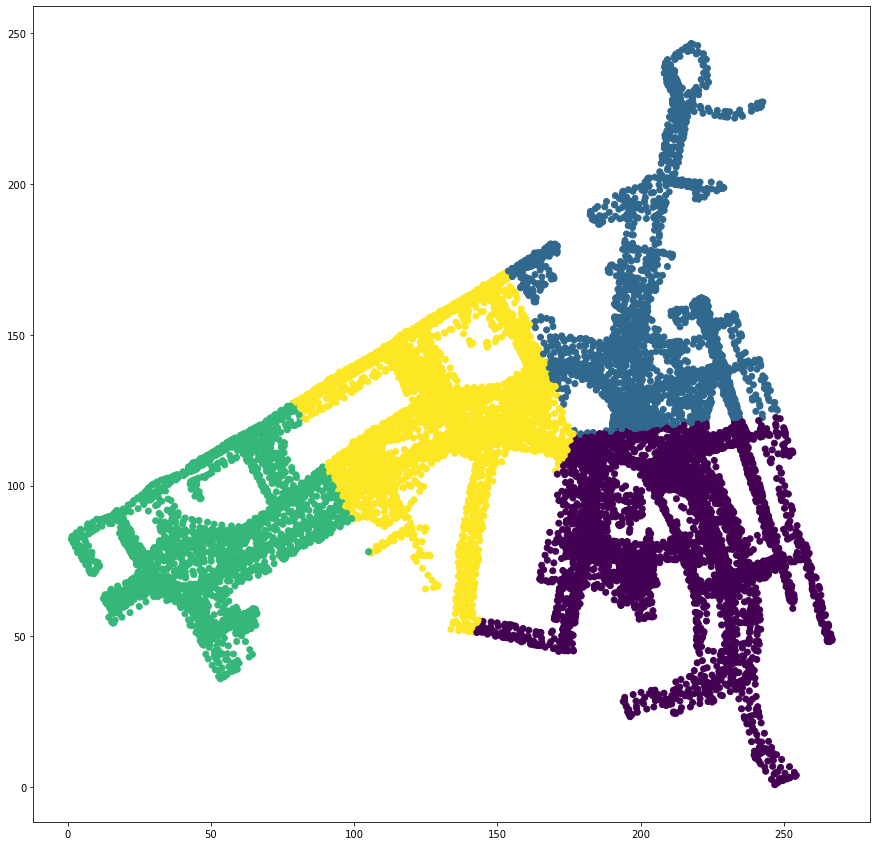

In [7]:
# Example:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))
plt.scatter(xyw.x,xyw.y,c=xyw.cluster)
plt.show()

We will use the floor information as a new feature to predict the XY coordinates in the next step.

Thank you for reading! Let me know if you have any question or suggestion.